# Module 25 Project Prompt

In this project, you'll participate in [Kaggle's Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) competition using a neural network.

From Kaggle:

> MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

> In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

You can use your preferred Neural Network framework. If using PyTorch, the example in the [documentation](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#creating-models) will help you get started.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Load training data

Load `train.csv` from Kaggle into a pandas DataFrame or use [PyTorch dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders) to load in the MNIST data.

Here I have also chosen to incorporate a normalization into the transform. The numbers 0.1307 and 0.3081
correspond to the mean and std of the MNIST dataset - as sourced from PyTorch datasheets.

### Batch training
Given the size of the training set - 60,000 records, with 784 incoming features etc, I am going to load the data in batches of 10 using DataLoader

In [2]:
def get_data_loaders():
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    with FileLock(os.path.expanduser("~/data.lock")):
        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                "~/data", train=True, download=True, transform=mnist_transforms
            ),
            batch_size=10,
            shuffle=True,
        )
        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                "~/data", train=False, download=True, transform=mnist_transforms
            ),
            batch_size=10,
            shuffle=True,
        )
    return train_loader, test_loader

### Create your neural network

Using your preferred framework (PyTorch or Keras), set up your network. The documentation from [Pytorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) may be helpful to get started.

In PyTorch, you will define the model class here.

### Defining convolutional model:
The model I have chosen follows:

CONV -> RELU -> MAXPOOL -> CONV -> RELU -> MAXPOOL -> FULLY CONNECTED -> RELU -> FULLY CONNECTED

With hidden layers set to [120,84]. 

##### First layer: 
We have 1 input channel as this is a grayscale image. I have decided to use 6 output channels for feature extraction initially. The kernel size is set to a 3x3 filter, and a stride of 1.

##### Second layer:
The second layer takes in the 6 output values from layer 1 as its inputs, and delivers to 16 output channels (again arbitrary choice) - again, 3x3 kernel, and stride 1

##### Fully connected layers:
The input size of the fully connected layer is determined by the effect of the kernel on the input image size. A 3x3 kernel with no padding applied to a 28x28 pixel image creates a 1 pixel edge on all sides, resulting in a 26x26 pixel image. I decided not to use padding because MNIST images are mostly black around the edges so we will not lose any crucial information by not implementing padding. If we apply the kernel twice, and maxpool layers twice, our resulting outputs will be:

$(((28-2)/2)-2)/2 = 5.5$ which rounds down to 5 pixels per side. It is divided by 2 each time because I have selected my maxpooling layers to be 2x2 with a stride of 2.



In [3]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1) # 1 input channel, 6 output channels, 3x3 kernel, stride=1
        self.conv2 = nn.Conv2d(6,16,3,1) # 6 input, 16 output, 3 kernel, stride=1
        self.fc1 = nn.Linear(5*5*16,120) # 5x5 pixel by 16 input, 120 neurons
        self.fc2 = nn.Linear(120,84) # 120 input to 84 output neurons
        self.fc3 = nn.Linear(84,10) # 84 to 10 outputs
        
    def forward(self,X):
        X = F.relu(self.conv1(X)) #relu activation applied to the first convolutional layer
        X = F.max_pool2d(X,2,2) # first maxpool layer, with 2x2 kernel, and stride of 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5) # flatten the image
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [4]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### Counting parameters of CNN

In [5]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [6]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


### Compile your model (if using `Keras`) and define optimizers

Since this is a multiclass classification problem, your loss function is `categorical_crossentropy` for Keras or `CrossEntropyLoss()` for PyTorch.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
# Chosen the Adam optimizer based on other examples. The learning rate is initially set to 0.01 arbitrarily

### Train the model

- Keras: Use your X_test, y_test from the `train_test_split` step for the `validation_data` parameter.
- PyTorch: Train the model by running a loop of epochs

In [8]:
from filelock import FileLock
import os


import time
start_time = time.time()

train_loader, test_loader = get_data_loaders()

# Define number of epochs - 10 chosen to begin with
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.09608393  accuracy:  89.510%
epoch:  0  batch: 2000 [ 20000/60000]  loss: 0.63001597  accuracy:  91.785%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.26712841  accuracy:  92.580%
epoch:  0  batch: 4000 [ 40000/60000]  loss: 0.11446147  accuracy:  92.998%
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.02329465  accuracy:  93.350%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.25377253  accuracy:  93.588%
epoch:  1  batch: 1000 [ 10000/60000]  loss: 0.43461394  accuracy:  95.270%
epoch:  1  batch: 2000 [ 20000/60000]  loss: 0.54377562  accuracy:  95.280%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.06898986  accuracy:  95.073%
epoch:  1  batch: 4000 [ 40000/60000]  loss: 0.00149070  accuracy:  95.157%
epoch:  1  batch: 5000 [ 50000/60000]  loss: 0.68659502  accuracy:  95.308%
epoch:  1  batch: 6000 [ 60000/60000]  loss: 0.01225174  accuracy:  95.347%
epoch:  2  batch: 1000 [ 10000/60000]  loss: 0.10704527  accuracy:  95.980%
epoch:  2  b

### Create your predictions and Overall performance (loss)

Display a few predictions and display a confusion matrix. Explain where your model fails with 1-2 sentences.

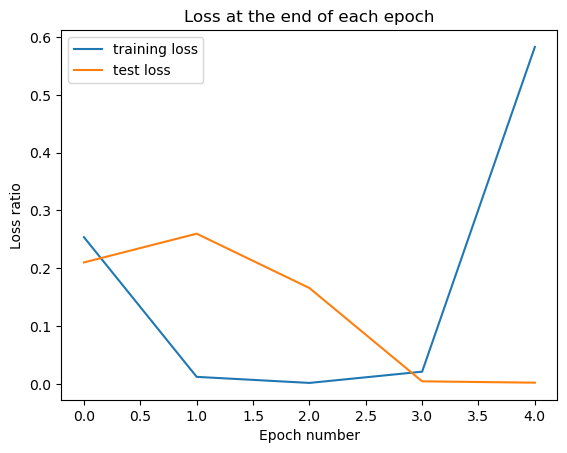

In [9]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('Epoch number')
plt.ylabel('Loss ratio')
plt.legend();

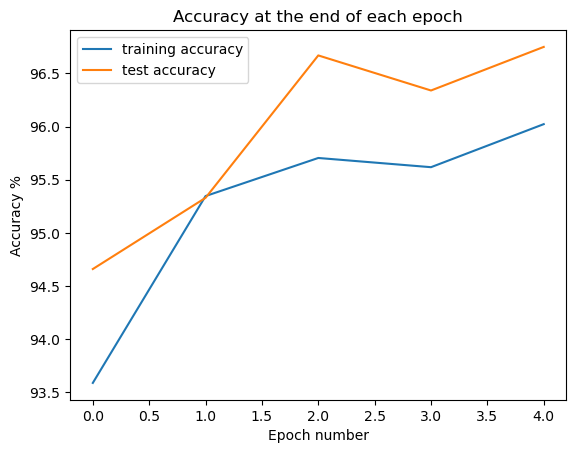

In [10]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.ylabel("Accuracy %")
plt.xlabel("Epoch number")
plt.legend();

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_data = datasets.MNIST(root='../Kaggle_data', train=False, download=True, transform=transform)
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9675/10000 =  96.750%


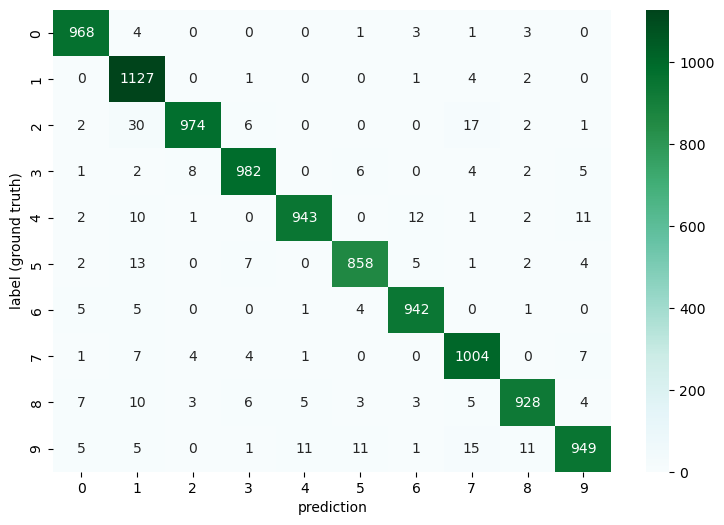

In [12]:
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
num_labels = [0,1,2,3,4,5,6,7,8,9]

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, num_labels, num_labels)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

We can see from the confusion matrix, the model appears to be classifying 2s as 1s quite a lot.

### Choose a hyperparameter and attempt to use your Bayesian Optimization code to optimize

After retraining the model with the "winning" hyperparameter value, tell us if it improved your loss.

For this section I have chosen to adopt a new model based on the PyTorch documentation around configurable neural networks. The below code is adapted from Ray-tune hyperparameter tuning. It uses the same convolutional neural network as above, and we are tuning the learning rate in this example.

In [13]:
import os
import argparse
from filelock import FileLock
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import ray
from ray import air, tune
from ray.air import session
from ray.tune.schedulers import AsyncHyperBandScheduler

    
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3,1) # 1 input channel, 6 output channels, 3x3 kernel, stride=1
        self.conv2 = nn.Conv2d(6,16,3,1) # 6 input, 16 output, 3 kernel, stride=1
        self.fc1 = nn.Linear(5*5*16,120) # 5x5 pixel by 16 input, 120 neurons
        self.fc2 = nn.Linear(120,84) # 120 input to 84 output neurons
        self.fc3 = nn.Linear(84,10) # 84 to 10 outputs
        
    def forward(self,X):
        X = F.relu(self.conv1(X)) #relu activation applied to the first convolutional layer
        X = F.max_pool2d(X,2,2) # first maxpool layer, with 2x2 kernel, and stride of 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5) # flatten the image
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)


def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    model.train()
    for b, (data, target) in enumerate(train_loader):
        b+=1
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for b, (data, target) in enumerate(data_loader):
            
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total


def train_mnist(config):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, test_loader = get_data_loaders()
    model = ConvNet().to(device)

    optimizer = optim.Adam(
        model.parameters(), lr=config["lr"]
    )

    while True:
        train(model, optimizer, train_loader, device)
        acc = test(model, test_loader, device)
        # Set this to run Tune.
        session.report({"mean_accuracy": acc})


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="PyTorch MNIST Example")
    parser.add_argument(
        "--cuda", action="store_true", default=False, help="Enables GPU training"
    )
    parser.add_argument(
        "--smoke-test", action="store_true", help="Finish quickly for testing"
    )
    parser.add_argument(
        "--ray-address",
        help="Address of Ray cluster for seamless distributed execution.",
    )
    parser.add_argument(
        "--server-address",
        type=str,
        default=None,
        required=False,
        help="The address of server to connect to if using Ray Client.",
    )
    args, _ = parser.parse_known_args()

    if args.server_address:
        ray.init(f"ray://{args.server_address}")
    elif args.ray_address:
        ray.init(address=args.ray_address)
    else:
        ray.init(num_cpus=2 if args.smoke_test else None)

    # for early stopping
    sched = AsyncHyperBandScheduler()

    resources_per_trial = {"cpu": 2, "gpu": int(args.cuda)}  # set this for GPUs
    tuner = tune.Tuner(
        tune.with_resources(train_mnist, resources=resources_per_trial),
        tune_config=tune.TuneConfig(
            metric="mean_accuracy",
            mode="max",
            scheduler=sched,
            num_samples=1 if args.smoke_test else 50,
        ),
        run_config=air.RunConfig(
            name="exp",
            stop={
                "mean_accuracy": 0.98,
                "training_iteration": 5 if args.smoke_test else 100,
            },
        ),
        param_space={
            "lr": tune.loguniform(1e-4, 1e-2),            
        },
    )
    results = tuner.fit()

    print("Best config is:", results.get_best_result().config)

2022-10-09 13:36:37,024	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-09 13:36:38,246	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,lr,acc,iter,total time (s)
train_mnist_04cb0_00000,TERMINATED,127.0.0.1:64422,0.00429638,0.982,5,169.513
train_mnist_04cb0_00001,TERMINATED,127.0.0.1:64430,0.00140029,0.9819,2,62.9379
train_mnist_04cb0_00002,TERMINATED,127.0.0.1:64431,0.00577031,0.968,1,31.927
train_mnist_04cb0_00003,TERMINATED,127.0.0.1:64432,0.00145538,0.9858,2,63.9606
train_mnist_04cb0_00004,TERMINATED,127.0.0.1:64431,0.000483278,0.977,1,32.8172
train_mnist_04cb0_00005,TERMINATED,127.0.0.1:64430,0.00617608,0.9753,1,34.6408
train_mnist_04cb0_00006,TERMINATED,127.0.0.1:64432,0.00180466,0.9808,1,33.5267
train_mnist_04cb0_00007,TERMINATED,127.0.0.1:64431,0.00733225,0.9509,1,34.4189
train_mnist_04cb0_00008,TERMINATED,127.0.0.1:64432,0.00446357,0.9765,1,35.723
train_mnist_04cb0_00009,TERMINATED,127.0.0.1:64430,0.000103915,0.9639,1,33.7673


Result for train_mnist_04cb0_00000:
  date: 2022-10-09_13-37-13
  done: false
  experiment_id: bbaeecec95dc4f20bc5179b5cd9a1843
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9707
  node_ip: 127.0.0.1
  pid: 64422
  time_since_restore: 31.955169916152954
  time_this_iter_s: 31.955169916152954
  time_total_s: 31.955169916152954
  timestamp: 1665319033
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00000
  warmup_time: 0.0042340755462646484
  
Result for train_mnist_04cb0_00001:
  date: 2022-10-09_13-37-16
  done: false
  experiment_id: dce32c68577d4b8c84571540f17fe581
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9797
  node_ip: 127.0.0.1
  pid: 64430
  time_since_restore: 31.127189874649048
  time_this_iter_s: 31.127189874649048
  time_total_s: 31.127189874649048
  timestamp: 1665319036
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00001
  warmup_time: 0.0

Result for train_mnist_04cb0_00011:
  date: 2022-10-09_13-39-32
  done: true
  experiment_id: dce32c68577d4b8c84571540f17fe581
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9714
  node_ip: 127.0.0.1
  pid: 64430
  time_since_restore: 35.90676498413086
  time_this_iter_s: 35.90676498413086
  time_total_s: 35.90676498413086
  timestamp: 1665319172
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00011
  warmup_time: 0.0034809112548828125
  
Result for train_mnist_04cb0_00012:
  date: 2022-10-09_13-39-35
  done: false
  experiment_id: 82362d5fe163433f9a5e934c67ef4cd7
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9782
  node_ip: 127.0.0.1
  pid: 64432
  time_since_restore: 37.01334810256958
  time_this_iter_s: 37.01334810256958
  time_total_s: 37.01334810256958
  timestamp: 1665319175
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00012
  warmup_time: 0.00337100

Result for train_mnist_04cb0_00027:
  date: 2022-10-09_13-42-04
  done: true
  experiment_id: 82362d5fe163433f9a5e934c67ef4cd7
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9794
  node_ip: 127.0.0.1
  pid: 64432
  time_since_restore: 35.9279727935791
  time_this_iter_s: 35.9279727935791
  time_total_s: 35.9279727935791
  timestamp: 1665319324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00027
  warmup_time: 0.003371000289916992
  
Result for train_mnist_04cb0_00028:
  date: 2022-10-09_13-42-06
  done: false
  experiment_id: 2965655e75dc4e79987f7d8bae4b21b3
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9796
  node_ip: 127.0.0.1
  pid: 64431
  time_since_restore: 37.44838619232178
  time_this_iter_s: 37.44838619232178
  time_total_s: 37.44838619232178
  timestamp: 1665319326
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00028
  warmup_time: 0.003844738006

Result for train_mnist_04cb0_00042:
  date: 2022-10-09_13-44-42
  done: true
  experiment_id: 82362d5fe163433f9a5e934c67ef4cd7
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.964
  node_ip: 127.0.0.1
  pid: 64432
  time_since_restore: 38.83865809440613
  time_this_iter_s: 38.83865809440613
  time_total_s: 38.83865809440613
  timestamp: 1665319482
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00042
  warmup_time: 0.003371000289916992
  
Result for train_mnist_04cb0_00043:
  date: 2022-10-09_13-44-59
  done: true
  experiment_id: dce32c68577d4b8c84571540f17fe581
  hostname: Chriss-MacBook-Pro-2.local
  iterations_since_restore: 1
  mean_accuracy: 0.9539
  node_ip: 127.0.0.1
  pid: 64430
  time_since_restore: 36.37139368057251
  time_this_iter_s: 36.37139368057251
  time_total_s: 36.37139368057251
  timestamp: 1665319499
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04cb0_00043
  warmup_time: 0.00348091125

2022-10-09 13:45:52,132	INFO tune.py:758 -- Total run time: 553.89 seconds (553.62 seconds for the tuning loop).


Best config is: {'lr': 0.0006774307743289721}


The result from the hyperparameter tuning reveals the optimum learning rate to be ~0.0007

In [14]:
ray.shutdown()

### Changing the learning rate to the optimum one:

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007) 
# Chosen the Adam optimizer based on other examples. The learning rate is initially set to 0.001 arbitrarily

### Re-training with the new tuned learning rate:

In [16]:
from filelock import FileLock
import os


import time
start_time = time.time()

train_loader, test_loader = get_data_loaders()

# Define number of epochs - 10 chosen to begin with
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.00003493  accuracy:  97.320%
epoch:  0  batch: 2000 [ 20000/60000]  loss: 0.00084439  accuracy:  97.550%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00048368  accuracy:  97.713%
epoch:  0  batch: 4000 [ 40000/60000]  loss: 0.00005652  accuracy:  97.782%
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.00008095  accuracy:  97.784%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.35465792  accuracy:  97.820%
epoch:  1  batch: 1000 [ 10000/60000]  loss: 0.00000002  accuracy:  97.970%
epoch:  1  batch: 2000 [ 20000/60000]  loss: 0.02463954  accuracy:  98.130%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.00163560  accuracy:  98.177%
epoch:  1  batch: 4000 [ 40000/60000]  loss: 0.05993523  accuracy:  98.230%
epoch:  1  batch: 5000 [ 50000/60000]  loss: 0.00297673  accuracy:  98.224%
epoch:  1  batch: 6000 [ 60000/60000]  loss: 0.00100132  accuracy:  98.237%
epoch:  2  batch: 1000 [ 10000/60000]  loss: 0.20473555  accuracy:  98.220%
epoch:  2  b

In [17]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9823/10000 =  98.230%


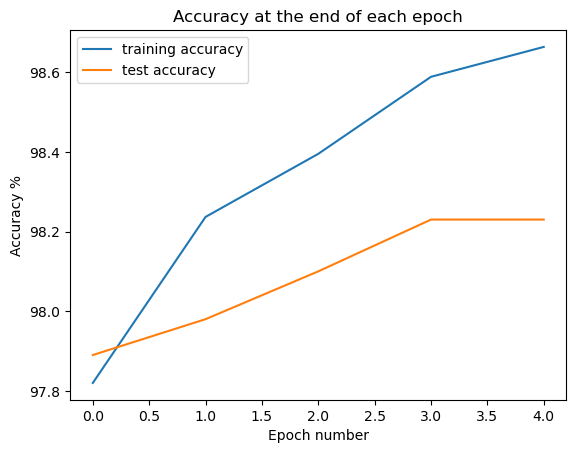

In [18]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.xlabel("Epoch number")
plt.ylabel("Accuracy %")
plt.legend();
plt.savefig('TunedLR.png')

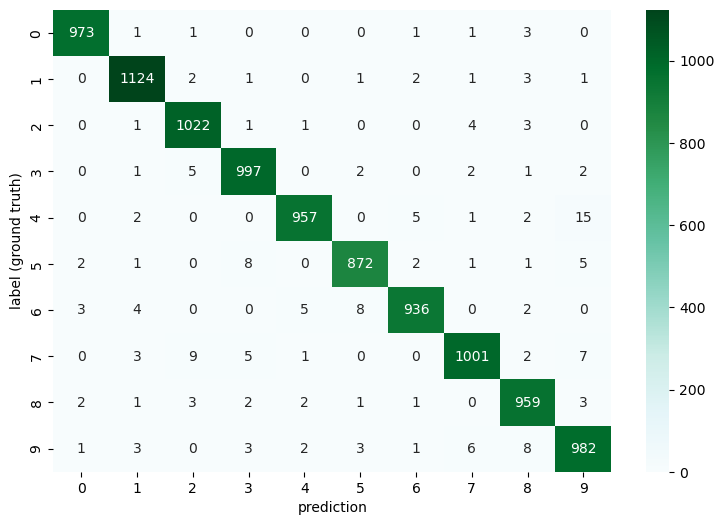

In [19]:
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, num_labels, num_labels)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

### Congrats on completing Module 25 project!